# Learning Gate - Reto | Mercadotecnia telefónica con aprendizaje supervisado

#### Data Science Fundamentals - Supervised ML (Classification)

## Introducción: 

Los programas de telemarketing se han venido usando por las empresas durante años como una forma de comunicarse con clientes potenciales de manera directa por vía telefónica. En los últimos años el uso de las técnicas de inteligencia artificial ha permitido potencializar el impacto de estos programas de mercadotecnia.

Un banco ha lanzado un nuevo plan de inversión a largo plazo a través de un programa de telemarketing y desea saber que tan exitoso se puede considerar este programa utilizando técnicas de aprendizaje supervisado. El programa es lanzado a clientes del banco, por lo que este estudio ayudará a optimizar los esfuerzos al conocer las características de los clientes más propensos a adquirir dicho plan de inversión.

 En la presente actividad tu objetivo es predecir si el entrevistado adquirirá el plan de inversión bancario de acuerdo con varias características que se conocen de dicho cliente. 

## Objetivo:  

Diseñar e implementar un modelo de aprendizaje supervisado que pueda predecir si una persona adquiere o no un plan de inversión bancaria a través de una entrevista telefónica.

## Indicaciones:

***A continuación, se describen los pasos a realizar en la presente actividad, en lo que llamaremos el Plan del Reto:***

- Deberás utilizar el archivo llamado bank_marketing.csv. con los datos de problema.
- Utilizar el archivo bank-names.txt para obtener información de cada una de las variables.
- Crear un proyecto tipo Jupyter Notebook en Google-Colab llamado Solucion_Reto_SC_63_<nombre_y_apellido_del_estudiante>.ipynb.
- Incluye las librerías que consideres adecuadas y carga los datos del archivo en una variable llamada “data”.
- Obtener la información de dicha base de datos que incluya el número de registros, el total de variables, el tipo de cada variable, la cantidad de datos perdidos de cada variable en caso de que existan.
- Transforma las variables categóricas de manera que puedan ser tratadas numéricamente. Justifica si utilizas LabelEncoder o OneHotEcoder.
- Transforma las variables numéricas en los casos que se tenga algún tipo de sesgo.
- Considera la variable “y” como la variable de salida y el resto de las variables como las variables de entrada.
- Particiona los datos en los conjuntos de entrenamiento, validación y prueba en 60%, 20% y 20%, respectivamente.
- Aplica el modelo Regresión Logística en el conjunto de entrenamiento. Valida el modelo con las predicciones del conjunto de validación y su matriz de confusión. Ajusta los parámetros del modelo hasta obtener tu mejor resultado.
- Aplica el modelo Red Neuronal en el conjunto de entrenamiento. Valida el modelo con las predicciones del conjunto de validación y su matriz de confusión. Ajusta los parámetros del modelo hasta obtener tu mejor modelo, entre ellos el número de neuronas y capas ocultas.
- Selecciona el mejor modelo encontrado en los incisos anteriores y utiliza el conjunto de prueba para obtener el desempeño final del modelo y su matriz de confusión.
- Incluye tus conclusiones del problema, en particular, ¿qué puedes decir acerca del uso de técnicas de inteligencia artificial en problemas de mercadotecnia?
- Descarga tu script (archivo con extensión .ipynb) y guárdalo siguiendo la nomenclatura que se te indica en Formato de entrega de actividad.
- Sube el archivo a GitHub.
- Copia y pega en un archivo de edición de texto la liga de tu archivo.


### Importing Libraries

In [1]:
import os, glob, math, copy
import numpy as np
import pandas as pd
import scipy as sci
import seaborn as sns
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

%matplotlib inline

C:\Users\alfde\AppData\Local\Temp\ipykernel_28220\1815324598.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


### Loading Data

In [2]:
path = os.path.join(os.getcwd(), 'Data')
files = glob.glob(os.path.join(path, '*.csv'))

df_base = pd.read_csv(files[0])
df = df_base.copy(deep=True)

- *Loaded Data:*

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,31,self-employed,married,tertiary,no,2666,no,no,cellular,10,nov,318,2,97,6,success,yes
1,29,unemployed,single,unknown,no,1584,no,no,cellular,6,sep,245,1,-1,0,unknown,yes
2,41,blue-collar,married,secondary,no,2152,yes,no,cellular,17,nov,369,1,-1,0,unknown,no
3,50,blue-collar,married,secondary,no,84,yes,no,cellular,17,jul,18,8,-1,0,unknown,no
4,40,admin.,married,secondary,no,0,no,no,cellular,28,jul,496,2,182,11,success,yes


#### Function to display results

In [4]:
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

## Exploratory Data Analysis

#### ***Input variables:***

- ***bank client data:***
  
    - 1 - age (numeric)
    - 2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services")
    - 3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
    - 4 - education (categorical: "unknown","secondary","primary","tertiary")
    - 5 - default: has credit in default? (binary: "yes","no")
    - 6 - balance: average yearly balance, in euros (numeric)
    - 7 - housing: has housing loan? (binary: "yes","no")
    - 8 - loan: has personal loan? (binary: "yes","no")

<br>

-  ***related with the last contact of the current campaign:***
-  
    - 9 - contact: contact communication type (categorical: "unknown","telephone","cellular")
    - 10 - day: last contact day of the month (numeric)
    - 11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
    - 12 - duration: last contact duration, in seconds (numeric)
      
<br>

- ***other attributes:***

    - 13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
    - 14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
    - 15 - previous: number of contacts performed before this campaign and for this client (numeric)
    - 16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

<br>

- ***Output variable (desired target):***

    - 17 - y - has the client subscribed a term deposit? (binary: "yes","no")

#### Dropping Unused Features

Features such as *default* and *load* were dropped due to their high bias toward a specific class. On the other hand, the feature *day* was dropped since no relevant information can be linked to the mentioned feature, since the year is unknown it cannot be defined if the day feature is related to a weekday or a weekend. It can be linked to specific paydays but it is unknown, and to keep the complexity as simple as possible this feature was removed from the analysis.

In [5]:
df.drop(['default', 'loan', 'day'], axis=1, inplace=True)

#### NaN Analysis

No missing values were found within the loaded data

In [6]:
pd.DataFrame(df.isna().sum(), columns=['NaN Vals']).transpose()

,age,job,marital,education,balance,housing,contact,month,duration,campaign,pdays,previous,poutcome,y
NaN Vals,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Frequencies within the loaded data features

It can be seen that some features, those with a reduced number of distinct classes, 20 max, can be considered categorical variables based on an empirical criterion.

In [7]:
pd.DataFrame(df.nunique(), columns=['Uniques']).transpose()

,age,job,marital,education,balance,housing,contact,month,duration,campaign,pdays,previous,poutcome,y
Uniques,74,12,3,4,3476,2,3,12,1327,34,437,31,4,2


### Analysis of Numerical Features

#### Statistics Summary

The non-categorical variables can be considered as ordinal numerical variables, and therefore, their statistics can be analyzed, as presented next. It can be seen that the features' variance varies considerably, increasing the possibility of using a scaler transformer to reduce amplitude bias effects on specific ML algorithms, such as logistic regression and support vector machine, among others. Additional analysis must be implemented to determine the variables' normality and their possible skewness.

In [8]:
cols2encode = df.nunique().index[(df.nunique().values<=20) & ((df.nunique().values>0))]
colsnum = [col for col in df.columns if col not in cols2encode]
df[colsnum].describe()

,age,balance,duration,campaign,pdays,previous
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,41.090556,1482.262778,353.832778,2.520111,50.511333,0.788889
std,11.664253,3031.013197,336.945158,2.737758,107.691963,2.210273
min,18.000000,-3058.000000,3.000000,1.000000,-1.000000,0.000000
25%,32.000000,109.000000,131.000000,1.000000,-1.000000,0.000000
50%,39.000000,519.000000,240.500000,2.000000,-1.000000,0.000000
75%,49.000000,1646.500000,462.000000,3.000000,-1.000000,0.000000
max,95.000000,81204.000000,3253.000000,58.000000,850.000000,58.000000


#### Transforming Numerical Features

After analyzing the variables' histograms, it was determined that variables such as *balance* and *duration* behave like Gaussian processes, but with skewness which complicates the use of logistic regression and SVM classifiers. Hence, logarithmic transformation was implemented to reduce the mentioned skewness, having as a result the following behaviours for the variables.

In [9]:
# Adjusting values within the balance variable to reduce skewness by using a logarithmic transformation
df.loc[:, 'balance'] = df.balance+np.abs(df.balance.min())+1
# Applying logarithmic transformation to skewed distributions
df.loc[:, 'balance'] = df.balance.apply(lambda x: np.log(x+np.min(x)))
df.loc[:, 'duration'] = df.duration.apply(lambda x: np.log(x))

- ***Plotting Distributions of numerical features and their relationships***

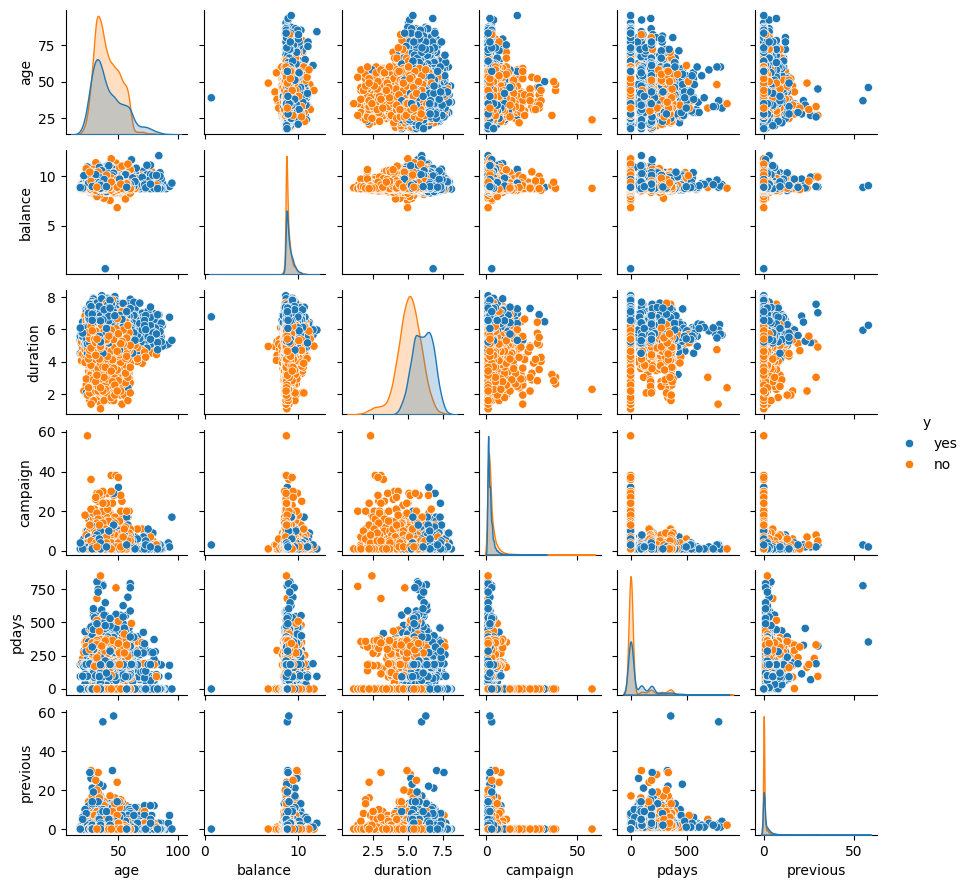

In [10]:
sns.pairplot(df[colsnum + ['y']], hue='y', height=1.5);

### Analysis of Categorical Features

#### Analyzing the frequencies of classes within the categorical features

After determining which features can be considered categorical variables, is it indispensable to determine the frequencies of the values that compose each of the variables, to reduce the effect of unbalanced classes that can diminish the performance of the selected ML methods. 

In [11]:
dfs = []
names = []
for col in cols2encode[:-1]:
    names.append(col)
    dfs.append(100*pd.DataFrame(df_base[col].value_counts()/df_base.shape[0]).rename(columns={'count':'Class %'}))

display_side_by_side(dfs, names)

,Class %
job,
management,22.211111
blue-collar,18.755556
technician,16.500000
admin.,11.155556
services,8.566667
retired,6.600000
self-employed,3.544444
student,3.466667
unemployed,3.222222


#### Encoding the categorical features

Once the categorical variables are filtered, they need to be converted into numerical variables for the ML methods to be able to find underlying patterns within the data to establish relationships with the dependent variable of interest.

In [12]:
cols2encode = df.nunique().index[(df.nunique().values<=20) & ((df.nunique().values>0))]
#df[df.nunique().index[(df.nunique().values<=20) & ((df.nunique().values>0))]]

enc = OrdinalEncoder(dtype=int)
df[cols2encode] = enc.fit_transform(df[cols2encode].values)

#### Normalizing features using a StandardScaler

Use of a standardscaler transformer to normalize feature variances around 1 and to remove their means, so then bias towards specific features will be removed, improving the performance of methods that rely on normally distributed data to find the needed relationships among the independent variables and the dependent variable of interest. 

In [13]:
# Using a standard scaler to prepare the data to be used as inputs to ML classifiers
scaler = StandardScaler()
df.loc[:, df.columns[:-1]] = scaler.fit_transform(df[df.columns[:-1]])

### Predicting the success of the telemarketing programs using supervised ML

#### Creating the training, validation and test sets

Three different datasets are created based on the provided data, these datasets will be used to train, validate and test the selected ML model. The training set contains around 75% of the total loaded data, while both the validation and test sets are composed of around 15% of the loaded data, each of them.

In [14]:
X = df[df.columns[:-1]].values
Y = df[['y']].values
X_train_base, X_test, y_train_base, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_base, y_train_base, test_size=0.15, random_state=42)

- *Exploring the percentage of the data sets concerning the loaded data*

In [15]:
print('Test set size percentage concerning the loaded data: ', X_test.shape[0]/df.shape[0])
print('Validation set size percentage concerning the loaded data: ', X_val.shape[0]/df.shape[0])
print('Train set size percentage concerning the loaded data: ', X_train.shape[0]/df.shape[0])

Test set size percentage concerning the loaded data:  0.15
Validation set size percentage concerning the loaded data:  0.12755555555555556
Train set size percentage concerning the loaded data:  0.7224444444444444


#### Finding the best set of hyperparameters to predict classes using supervised ML

Four different methods were selected to create the needed classifier:

- LogisticRegression

- Random Forest

- Support Vector Machines

- Neural Networks

The objective is to determine the best model to generate the best results for the problem we are trying to solve, the determination of clients who will buy the telemarketing campaign.

In the following sections, the sklearn GridSearchCV method is used to evaluate different combinations of predefined hyperparameter values on the mentioned models, to determine the best combination of parameters that generate the model with the best performance, for each of the presented ML algorithms.

- ***Logistic Regression Classifier:***



In [16]:
model_lg = None
score = 0
penalties = {'newton-cg':['l2'], 'saga':['elasticnet'], 'lbfgs':['l2'], 'liblinear':['l1', 'l2'],
             'newton-cholesky':['l2']}
for solver in ['newton-cg', 'saga', 'lbfgs', 'liblinear', 'newton-cholesky']:
    params = {'C':[.05, .1, .15, .2, .3, .5, .7, .9, 1], 'penalty':penalties[solver], 'solver':[solver]}
    if solver == 'saga':
        params['l1_ratio'] = [.1, .2, .3, .4, .5, .7, .8]
    LG_grid = LogisticRegression()
    clf_search = GridSearchCV(LG_grid, params, error_score='raise')
    clf_search.fit(X_train,y_train.transpose()[0])
    if clf_search.best_score_ > score:
        score = clf_search.best_score_
        model_lg = clf_search

print('Model Search: ', model_lg)
print('\n')
print('Best model parameters: ', model_lg.best_params_, '\nBest model Score:', model_lg.best_score_)


Model Search:  GridSearchCV(error_score='raise', estimator=LogisticRegression(),
             param_grid={'C': [0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 0.9, 1],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']})


Best model parameters:  {'C': 0.05, 'penalty': 'l1', 'solver': 'liblinear'} 
Best model Score: 0.7983732040442263


- ***RandomForest Classifier:***

In [17]:
hyperparameters = {'n_estimators':[10, 20, 50, 100, 200], 'max_depth':[2, 5, 10], 'min_samples_split':[2, 3,4,5],
                   'criterion':['gini', 'entropy', 'log_loss']}
Forest_grid = RandomForestClassifier(random_state=0)
model_RF = GridSearchCV(Forest_grid, hyperparameters)
model_RF.fit(X_train,y_train.transpose()[0])

print('Model Search: ', model_RF)
print('\n')
print('Best model parameters: ', model_RF.best_params_, '\nBest model Score:', model_RF.best_score_)

Model Search:  GridSearchCV(estimator=RandomForestClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 5, 10],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [10, 20, 50, 100, 200]})


Best model parameters:  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100} 
Best model Score: 0.8398979483237745


- ***Support Vector Machine Classifier:***

In [18]:
model_svc = None
score = 0

for solver in ['poly', 'rbf', 'sigmoid']:
    params = {'C':[.05, .15, .2, .3, .5, .7, .8, 1], 'kernel':[solver]}
    if solver == 'poly':
        params['degree'] = [2,3,4,5]
    else:
        params['gamma'] = ['auto', 'scale']
    if solver in ['poly', 'sigmoid']:
        params['coef0'] = [0, .1, .5, .7, 1]
    
    SVC_grid = SVC(random_state=0)
    clf_search = GridSearchCV(SVC_grid, params)
    clf_search.fit(X_train,y_train.transpose()[0])

    if clf_search.best_score_ > score:
        score = clf_search.best_score_
        model_svc = clf_search

print('Model Search: ', model_svc)
print('\n')
print('Best model parameters: ', model_svc.best_params_, '\nBest model Score:', model_svc.best_score_)

Model Search:  GridSearchCV(estimator=SVC(random_state=0),
             param_grid={'C': [0.05, 0.15, 0.2, 0.3, 0.5, 0.7, 0.8, 1],
                         'gamma': ['auto', 'scale'], 'kernel': ['rbf']})


Best model parameters:  {'C': 0.5, 'gamma': 'auto', 'kernel': 'rbf'} 
Best model Score: 0.8215962868799149


- ***Neural Network Classifier:***

In [19]:
model_mlp = MLPClassifier(hidden_layer_sizes=(20,), random_state=0, max_iter=500, activation='relu',
                          learning_rate_init=0.0015, alpha=.109, batch_size=400)
model_mlp.fit(X_train,y_train.transpose()[0])

print('Model Search: ', model_mlp)
print('\n')
print('Best model Score:', model_mlp.score)


Model Search:  MLPClassifier(alpha=0.109, batch_size=400, hidden_layer_sizes=(20,),
              learning_rate_init=0.0015, max_iter=500, random_state=0)


Best model Score: <bound method ClassifierMixin.score of MLPClassifier(alpha=0.109, batch_size=400, hidden_layer_sizes=(20,),
              learning_rate_init=0.0015, max_iter=500, random_state=0)>


#### Analyzing the learning process of the generated classifiers

In addition to the previous analysis, the best models for each of the selected ML algorithms are analysed, in terms of their learning process, to determine if the models are underfitting or overfitting the data. This is possible by comparing the learning curves when training and validating the model, as presented next:

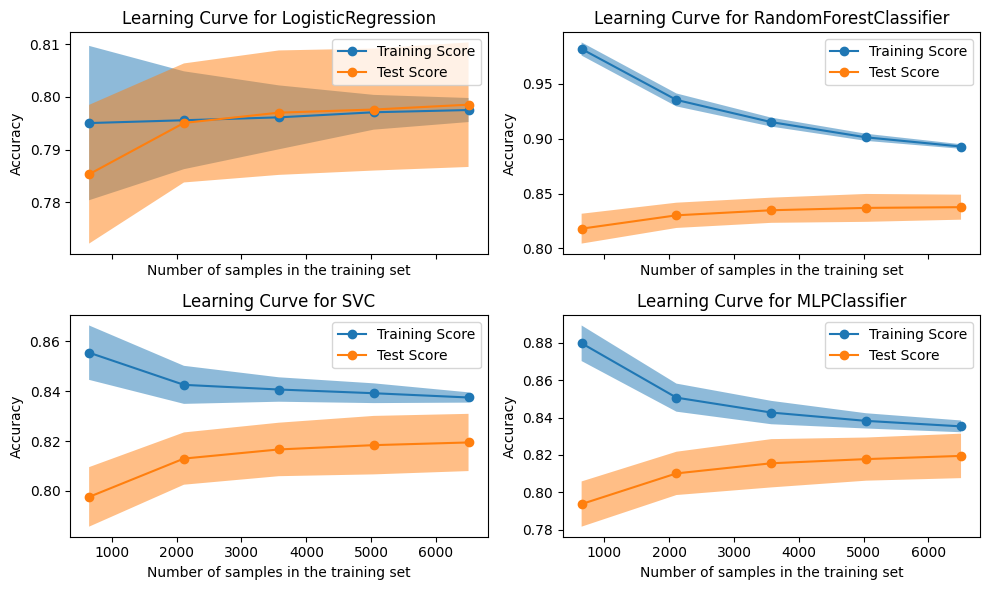

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), sharex=True)

common_params = {
    "X": X_train_base,
    "y": y_train_base,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.15, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

clf_lg = LogisticRegression(C=.05, solver='liblinear', random_state=0, penalty='l1')
clf_rf = RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_split=2, n_estimators=100, random_state=0)
clf_svc = SVC(C=0.5, gamma='auto', kernel='rbf', random_state=0)
clf_mlp = MLPClassifier(hidden_layer_sizes=(20,), random_state=0, max_iter=500, activation='relu',
                        learning_rate_init=0.0015, alpha=.109, batch_size=400)

count1 = 0
count2 = 0
for ax_idx, estimator in enumerate([clf_lg, clf_rf, clf_svc, clf_mlp]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[count1, count2])
    handles, label = ax[count1, count2].get_legend_handles_labels()
    ax[count1, count2].legend(handles[:2], ["Training Score", "Test Score"])
    ax[count1, count2].set_title(f"Learning Curve for {estimator.__class__.__name__}")
    count2 += 1
    if count2 == 2:
        count1 = 1
        count2 = 0

plt.tight_layout()

It can be concluded, based on the previous Figures, that the four trained models deliver satisfactory results, in terms of their learning process. The convergency of the training and validations curves means that the models are reaching the same performance, and therefore, the overfitted of data is not a big issue on the trained models. However, it can be seen in the RanfomForest model that the curves are not too close to each other can be a good indicator of the presence to overfitting to some degree, especially when compared to the other models. 

#### Analyzing the performing of the trained models

To complement the previous performance analysis for the trained models, additional metrics are also considered, such as the accuracy score and the confusion matrix, being the latter the most important one to determine the effectiveness of the trained models:

In [21]:
cases = 50
scores_avg = [0, 0, 0, 0]
dfs = []
names = ['Logistic', 'RandomForest', 'SVC', 'MLP']
conf_mtrxs = [np.zeros(shape=(2, 2)), np.zeros(shape=(2, 2)), np.zeros(shape=(2, 2)), np.zeros(shape=(2, 2))]
clf_lg = LogisticRegression(C=.05, solver='liblinear', random_state=0, penalty='l1')
clf_rf = RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_split=2, n_estimators=100, random_state=0)
clf_svc = SVC(C=0.5, gamma='auto', kernel='rbf', random_state=0)
clf_mlp = MLPClassifier(hidden_layer_sizes=(20,), random_state=0, max_iter=500, activation='relu',
                        learning_rate_init=0.0015, alpha=.109, batch_size=400)


for i, clf in enumerate([clf_lg, clf_rf, clf_svc, clf_mlp]):
    for n in range(cases):    
        X_train, X_val, y_train, y_val = train_test_split(X_train_base, y_train_base, test_size=0.15)
        clf.fit(X_train,y_train.transpose()[0])
        scores_avg[i] += accuracy_score(clf.predict(X_val), y_val)
        conf_mtrxs[i] += confusion_matrix(y_val, clf.predict(X_val))
    scores_avg[i] = scores_avg[i]/cases
    conf_mtrxs[i] = np.floor(conf_mtrxs[i]/cases)
    dfs.append(pd.DataFrame(conf_mtrxs[i], columns = ['Real +', 'Real -'], index=['Pred +', 'Pred -']).astype(int))

print('Models Performance')
display(pd.DataFrame({'Accuracy':scores_avg}, index=names))

print()
print('Confusion Matrices')
display_side_by_side(dfs, names)

Models Performance


,Accuracy
Logistic,0.795366
RandomForest,0.835436
SVC,0.818310
MLP,0.816969



Confusion Matrices


,Real +,Real -
Pred +,554,114
Pred -,120,359
,Real +,Real -
Pred +,570,97
Pred -,91,388
,Real +,Real -
Pred +,555,112
Pred -,95,383
,Real +,Real -
Pred +,560,103


Thus, based on the presented metrics, it can be concluded that the trained RandomForest model provides better performance for the problem we are trying to solve since it classified the higher number of real positives and negatives with a similar performance concerning the other models' misclassifying cases.

#### ROC Curve for the trained classifier

An additional validation layer can be implemented based on the ROC curve, as presented in the next Figure. The AUC of the ROC curve is .92, for the true positive cases, meaning that there is a high probability of correctly identifying clients that will buy the telemarketing campaign using the selected model. 

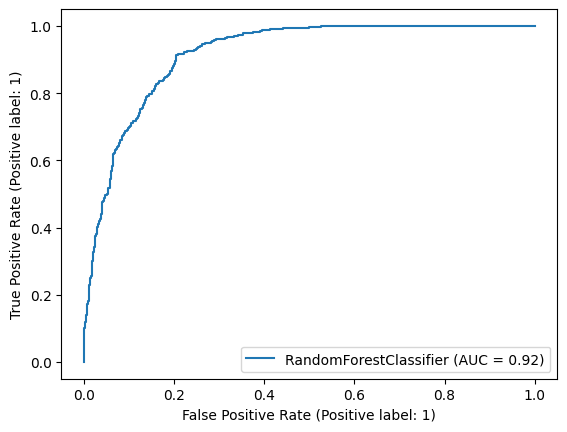

In [22]:
svc_disp = RocCurveDisplay.from_estimator(clf_rf, X_test, y_test)
plt.show()

### Prediction for the telemarketing program

As a result, the selected trained RandomForest model can be used to determine clients that can buy the telemarketing program, as presented next:

In [23]:
print('Predictions Accuracy:', accuracy_score(clf_rf.predict(X_test), y_test))

print()
print('Matriz de Confusion')
display(pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test)), columns = ['Real +', 'Real -'], index=['Pred +', 'Pred -']).astype(int))


Predictions Accuracy: 0.8325925925925926

Matriz de Confusion


,Real +,Real -
Pred +,638,112
Pred -,129,471


When the mentioned model is used on the test dataset to evaluate the real performance of the model, the performance of the model with an unseen dataset, we can see that it classified correctly 632 cases of real positives, and 468 cases of real negatives, while it misclassified 132 and 118 cases as real and false positives, respectively. It should be possible to increase the performance of the classification results, by increasing the complexity of the models used to implement the classification, such as the use of boosting or voting assembled methods, among others. Nevertheless, there will exist always the risk of increasing overfitting by increasing the complexity of the used methods. 

## FIN